<a href="https://colab.research.google.com/github/KeshavSaraf/HospitalLocator-BE/blob/main/Deep_Learning_DA_2_(22BDS0241).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Keshav Saraf (22BDS0241)

---

### [Colab Notebook](https://colab.research.google.com/drive/1GFaGNlU0DBuhrvZBsC4BkNeWLld3ulU1)

## Fashion-MNIST Image Classification

In [ ]:
!pip install -q optuna scikeras
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


In [ ]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import regularizers
import optuna
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

#### 1. Dataset Loading and Preprocessing

In [ ]:
# Loading data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
# Preprocessing

# Normalizing from 0 - 255 to 0 - 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One hot encoding
y_train = y_train.astype("int")
y_test = y_test.astype("int")
y_train_labels_h = to_categorical(y_train)
y_test_labels_h = to_categorical(y_test)

# Data augmentation (Adding some images with random noise pixels)
def add_noise(img):
    noise = np.random.normal(loc=0.0, scale=0.1, size=img.shape)
    noisy_img = img + noise
    noisy_img = np.clip(noisy_img, 0.0, 1.0)
    return noisy_img

def noisy_images_labels(x, y):
    random_indices = np.random.choice(x.shape[0], size=x.shape[0]//5, replace=False)
    x_selected = x[random_indices]
    y_selected = y[random_indices]
    x_noisy = add_noise(x_selected)
    return x_noisy, y_selected

x_train_noisy, y_train_selected = noisy_images_labels(x_train, y_train_labels_h)
x_test_noisy, y_test_selected = noisy_images_labels(x_test, y_test_labels_h)

augmented_x_train = np.concatenate([x_train, x_train_noisy], axis=0)
augmented_y_train = np.concatenate([y_train_labels_h, y_train_selected], axis=0)
augmented_x_test = np.concatenate([x_test, x_test_noisy], axis=0)
augmented_y_test = np.concatenate([y_test_labels_h, y_test_selected], axis=0)

---
Explanation
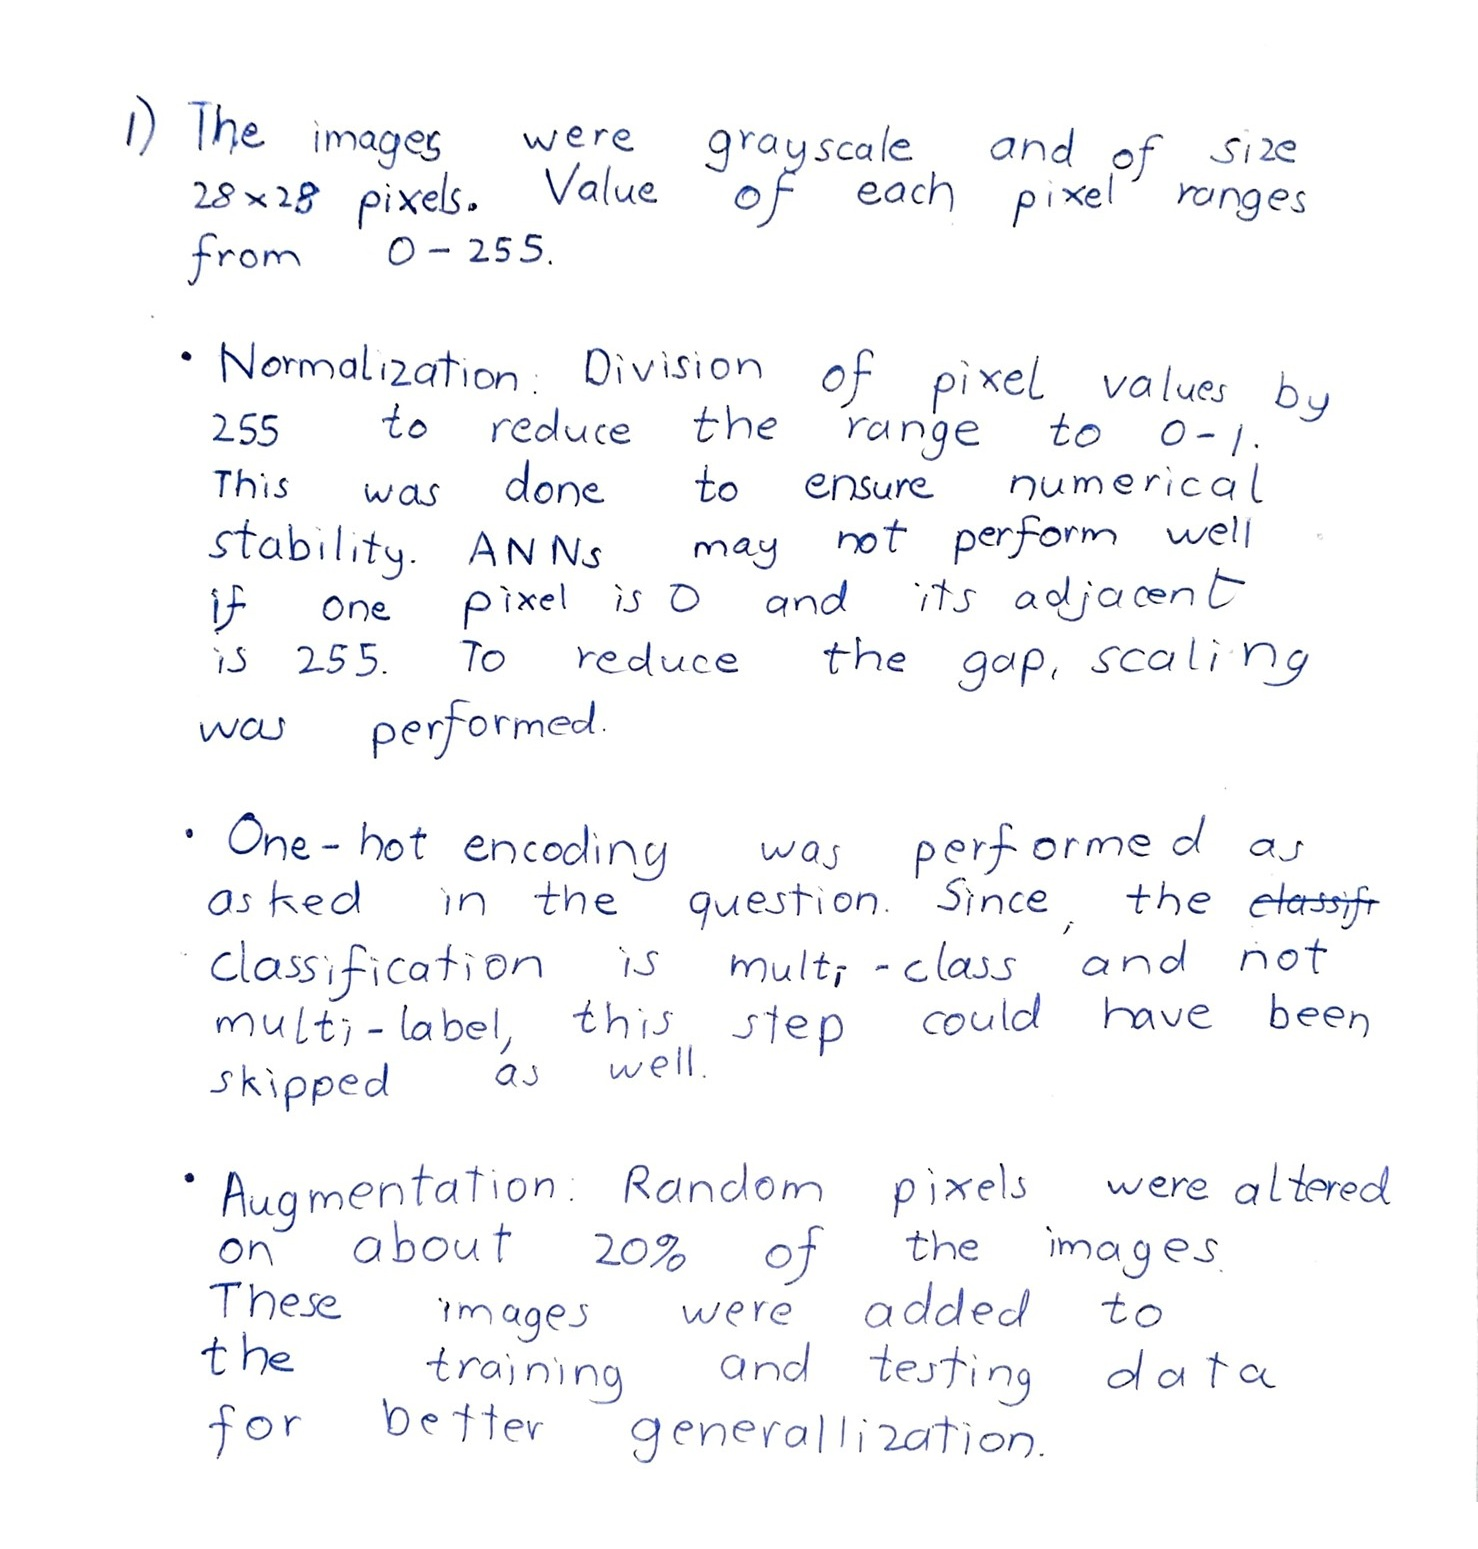

---

#### 2. Model Architecture:

In [ ]:
# Function to create a compiled model
def create_model(
        hidden_layers=1,
        base_units=32,
        unit_multiplier=np.sqrt(2),
        min_units_for_dropout=128,
        dropout=0.1,
        activation='relu',
        optimizer='adam',
        initial_learning_rate=0.001,
        l2_reg=0.0
    ):
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    model.add(Flatten())

    reg = regularizers.l2(l2=l2_reg)

    for i in range(hidden_layers):
        units = int(base_units * (unit_multiplier ** (hidden_layers - i - 1)))
        model.add(Dense(
            units=units,
            activation=activation,
            kernel_initializer='he_normal' if activation in 'relu' else 'glorot_uniform',
            kernel_regularizer=reg
        ))
        model.add(BatchNormalization())
        if units > min_units_for_dropout:
            model.add(Dropout(dropout))

    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

---
Explanation
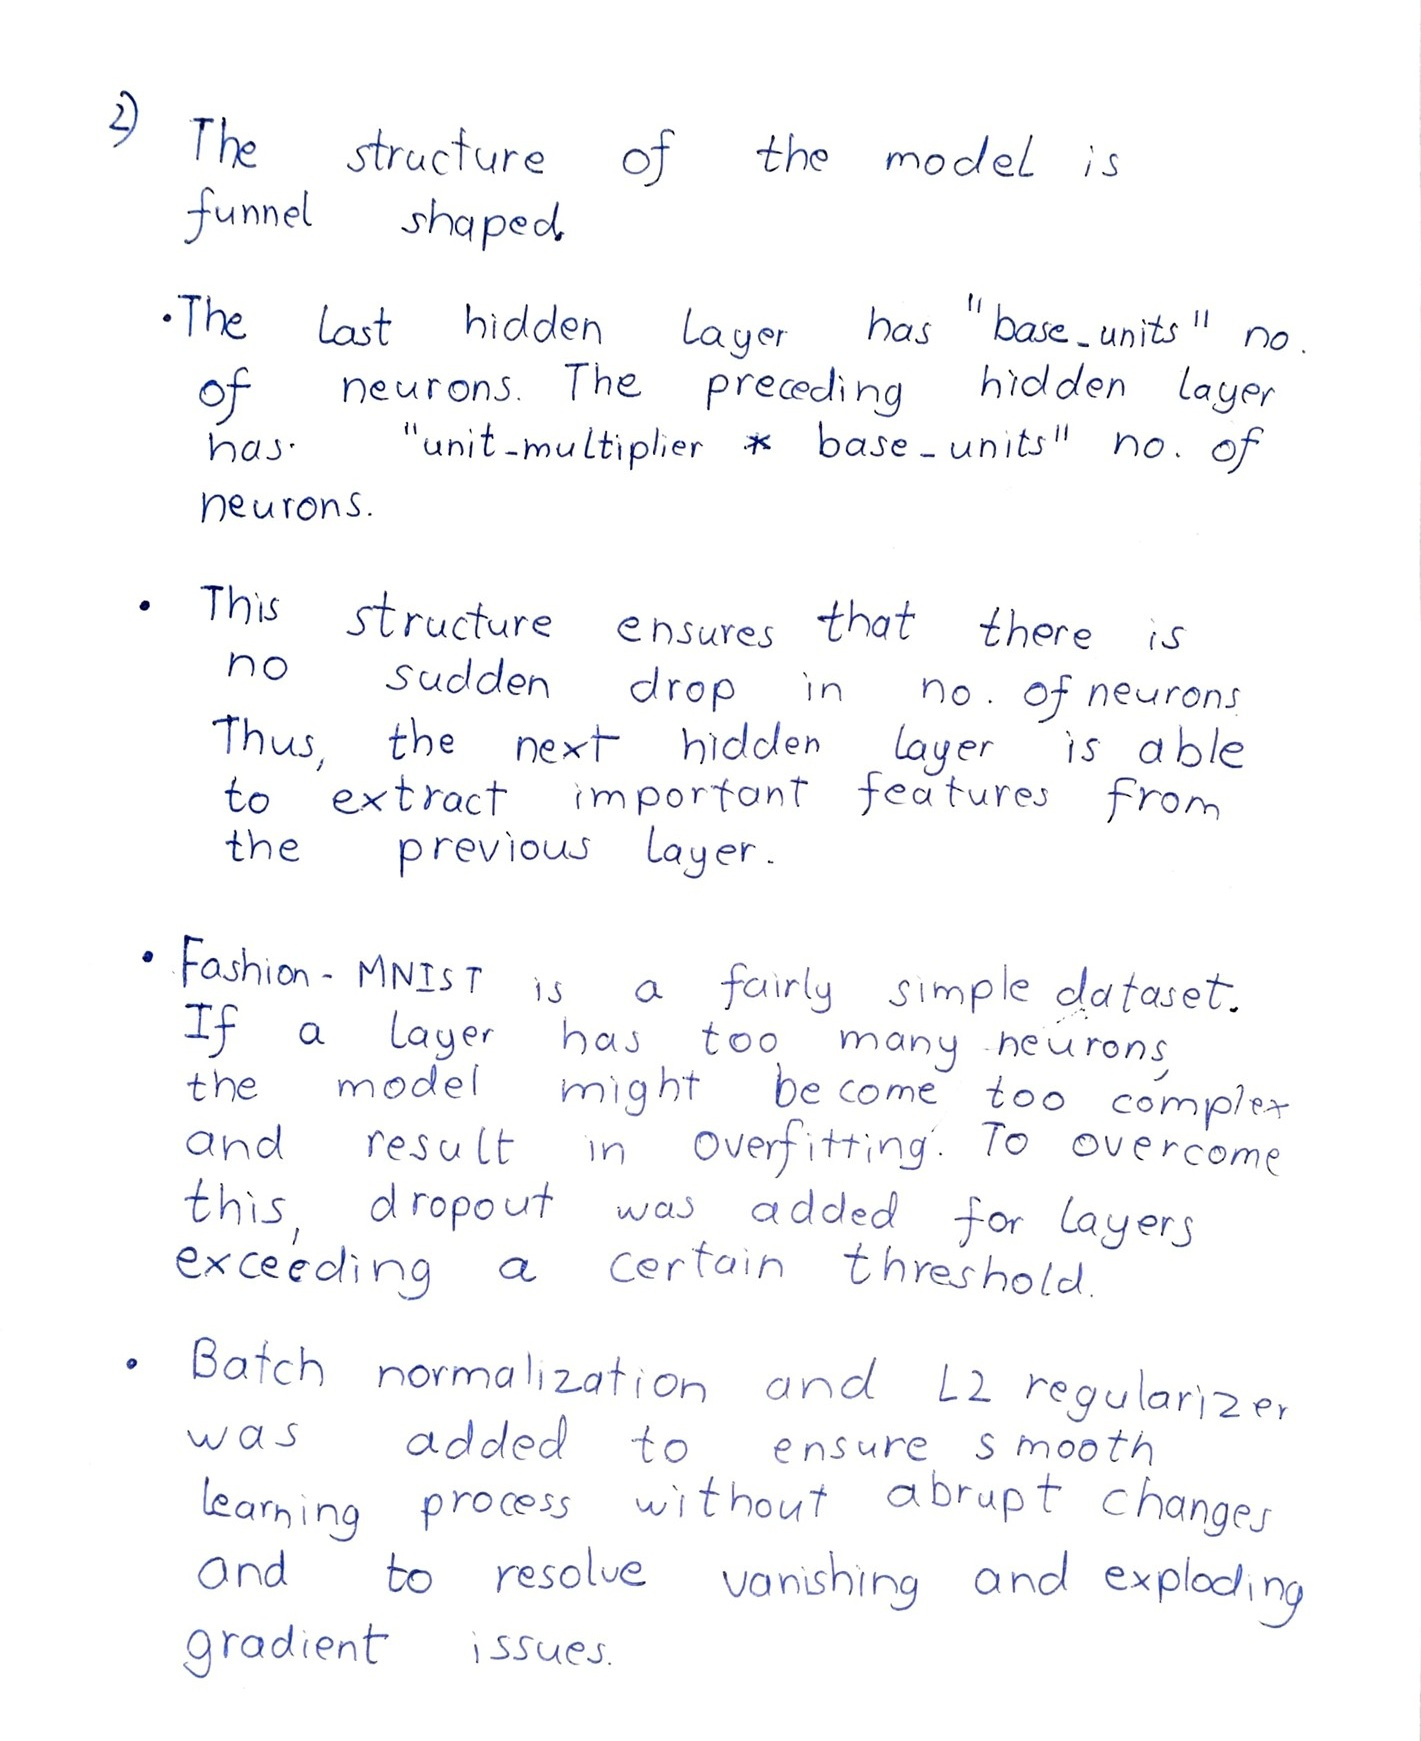

---

#### 3. Tune all hyperparameters

In [ ]:
# Adaptive Learning Rate and EarlyStopping callbacks for hyperparameter tuning
def create_callbacks(initial_lr):
    callbacks = []

    reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.4,
            patience=3,
            min_lr=1e-6,
            verbose=1
    )
    callbacks.append(reduce_lr)

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
    callbacks.append(early_stop)

    return callbacks

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    hidden_layers = trial.suggest_int('hidden_layers', 2, 5)
    base_units = trial.suggest_int('base_units', 32, 128)
    unit_multiplier = trial.suggest_float('unit_multiplier', 1.1, 1.5)
    min_units_for_dropout = trial.suggest_int('min_units_for_dropout', 128, 256)
    dropout = trial.suggest_float('dropout', 0.12, 0.21)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    initial_learning_rate = trial.suggest_float('initial_learning_rate', 1e-4, 1e-2, log=True)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_int('batch_size', 64, 128)
    epochs = trial.suggest_int('epochs', 7, 21)

    # Define model builder
    def generate_model():
        return create_model(
            hidden_layers=hidden_layers,
            base_units=base_units,
            unit_multiplier=unit_multiplier,
            min_units_for_dropout=min_units_for_dropout,
            dropout=dropout,
            activation=activation,
            optimizer=optimizer,
            initial_learning_rate=initial_learning_rate,
            l2_reg=l2_reg
        )

    # Wrap with KerasClassifier
    callbacks = create_callbacks(initial_learning_rate)
    model = KerasClassifier(model=generate_model, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=callbacks)

    # Cross-validation score (5-fold)
    score = cross_val_score(model, augmented_x_train, augmented_y_train, cv=5, scoring='accuracy', n_jobs=-1)
    return score.mean()

In [ ]:
# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, timeout=None)

[I 2025-08-12 08:00:16,616] A new study created in memory with name: no-name-ff288c1a-21e6-4978-95ef-daad8ba0bab5
[I 2025-08-12 08:04:08,843] Trial 0 finished with value: 0.8684722222222222 and parameters: {'hidden_layers': 3, 'base_units': 89, 'unit_multiplier': 1.3301571794214602, 'min_units_for_dropout': 166, 'dropout': 0.1690494655747463, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'initial_learning_rate': 0.002623653918670019, 'l2_reg': 0.00010822796441540857, 'batch_size': 77, 'epochs': 21}. Best is trial 0 with value: 0.8684722222222222.
[I 2025-08-12 08:06:50,312] Trial 1 finished with value: 0.8788750000000001 and parameters: {'hidden_layers': 4, 'base_units': 67, 'unit_multiplier': 1.4925365750911483, 'min_units_for_dropout': 232, 'dropout': 0.1861611631538549, 'activation': 'relu', 'optimizer': 'sgd', 'initial_learning_rate': 0.0002248975378008131, 'l2_reg': 0.0002006562271788173, 'batch_size': 71, 'epochs': 14}. Best is trial 1 with value: 0.8788750000000001.
/usr/loca

---
Explanation
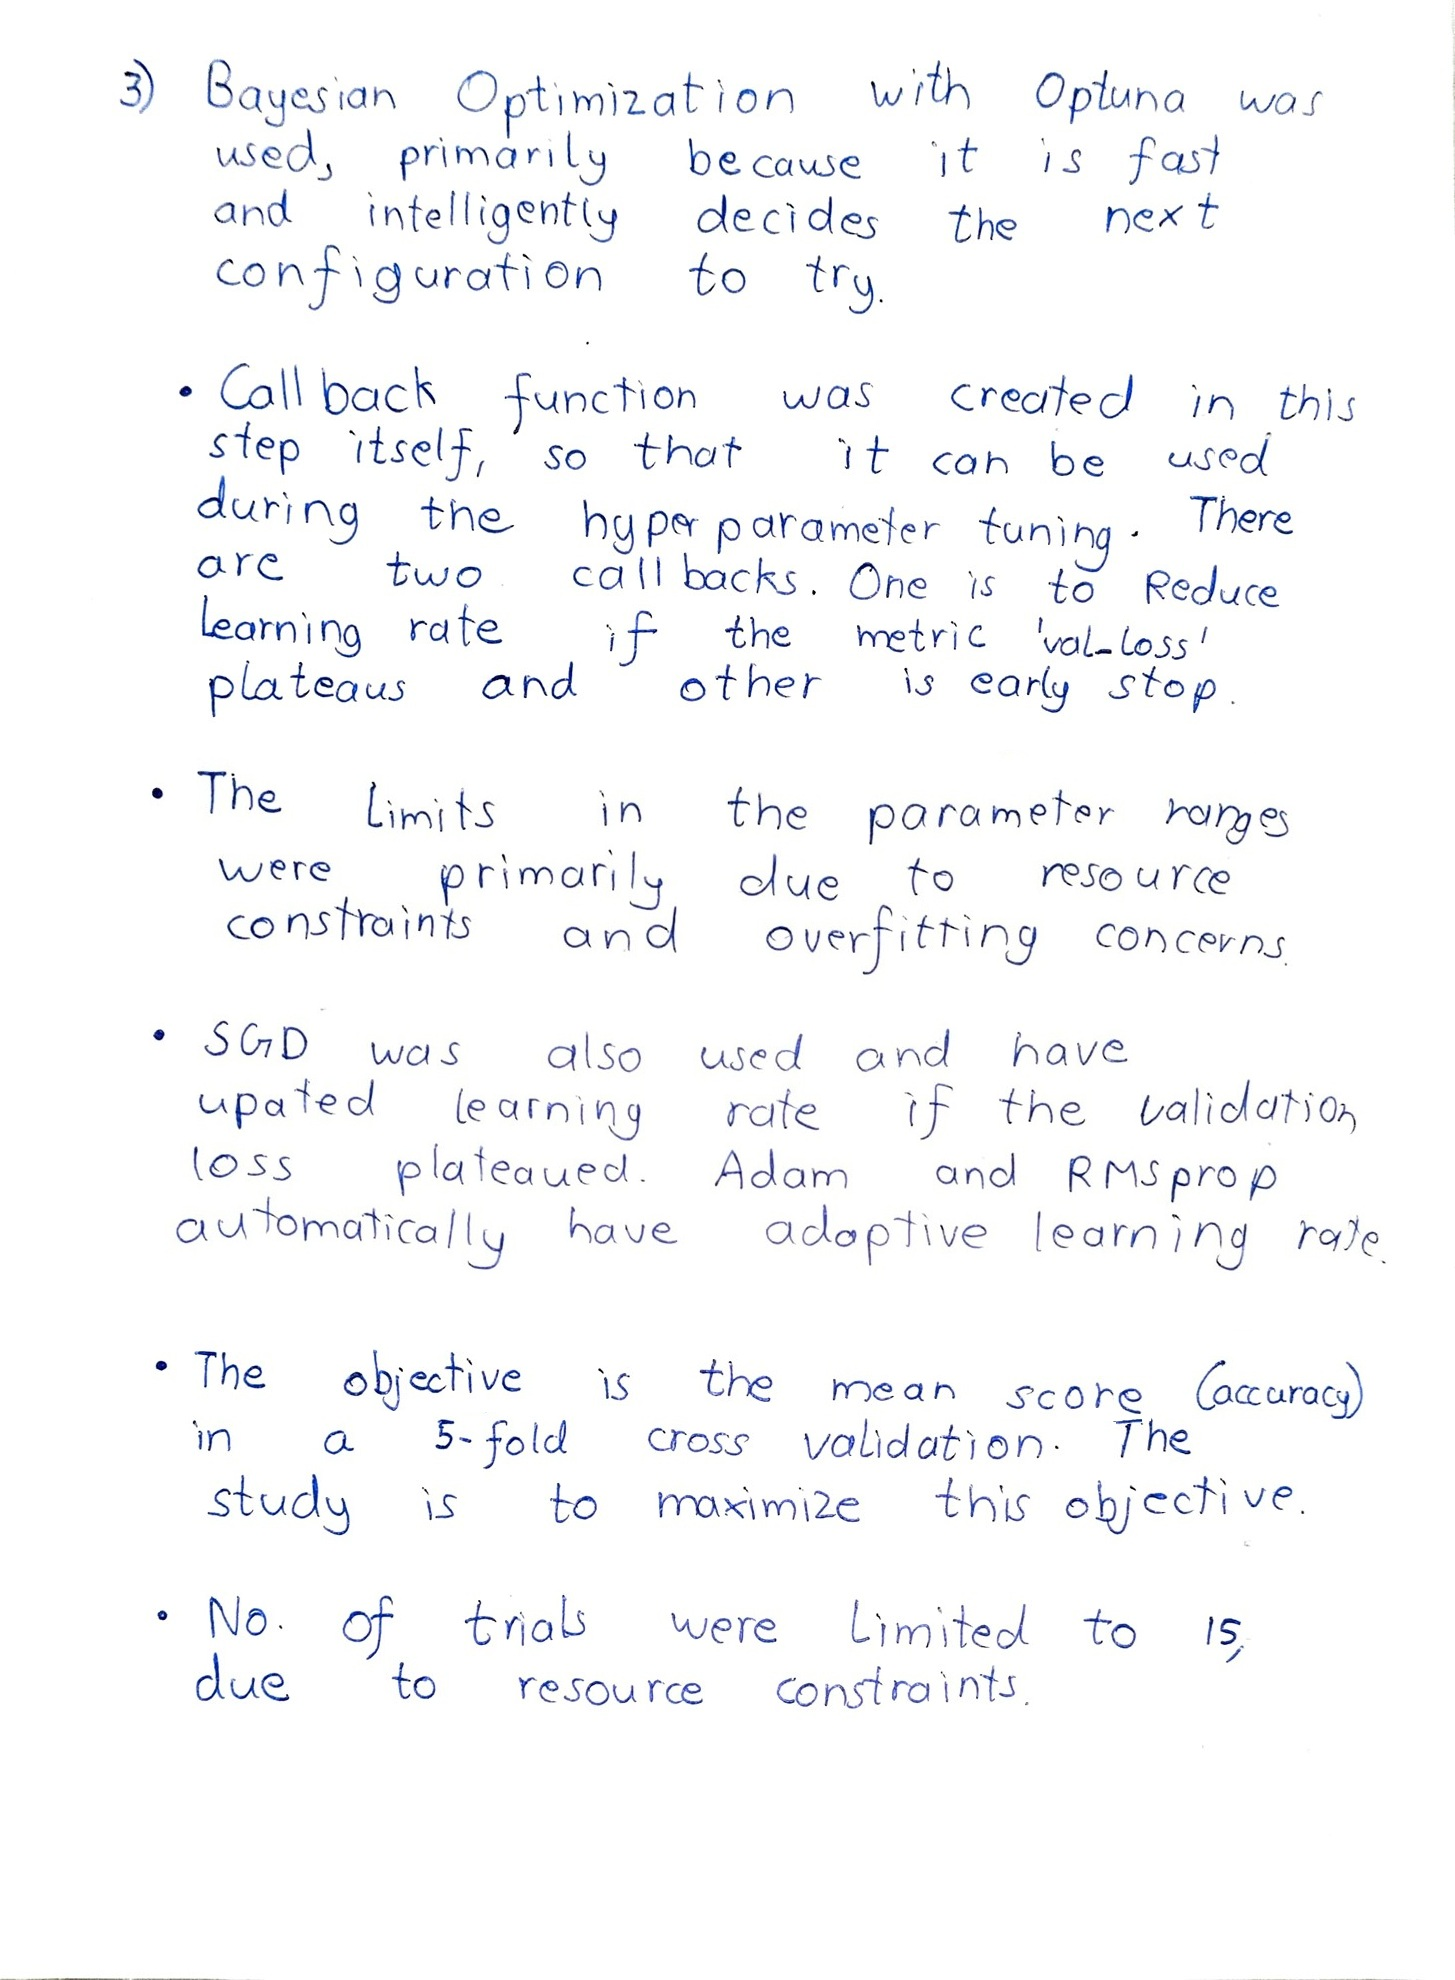

---

#### 4. Implement early stopping

In [ ]:
# Use the best hyperparameters from tuning
best_params = study.best_params

In [ ]:
# Extract values
hidden_layers = best_params['hidden_layers']
base_units = best_params['base_units']
unit_multiplier = best_params['unit_multiplier']
min_units_for_dropout = best_params['min_units_for_dropout']
dropout = best_params['dropout']
activation = best_params['activation']
optimizer_name = best_params['optimizer']
initial_learning_rate = best_params['initial_learning_rate']
l2_reg = best_params['l2_reg']
batch_size = best_params['batch_size']
epochs = best_params['epochs']

# Choose optimizer
if optimizer_name == 'adam':
    optimizer = Adam()
elif optimizer_name == 'sgd':
    optimizer = SGD()
elif optimizer_name == 'rmsprop':
    optimizer = RMSprop()

In [ ]:
# Create final model
model = create_model(
    hidden_layers=hidden_layers,
    base_units=base_units,
    unit_multiplier=unit_multiplier,
    min_units_for_dropout=min_units_for_dropout,
    dropout=dropout,
    activation=activation,
    optimizer=optimizer,
    initial_learning_rate=initial_learning_rate,
    l2_reg=l2_reg
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 342)            │       268,470 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 342)            │         1,368 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 262)            │        89,866 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 262)            │         1,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 262)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 201)            │        52,863 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 201)            │           804 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 154)            │        31,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 154)            │           616 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 118)            │        18,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 118)            │           472 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 466,095 (1.78 MB)

 Trainable params: 463,941 (1.77 MB)

 Non-trainable params: 2,154 (8.41 KB)

In [ ]:
# Train final model
callbacks = create_callbacks(best_params['initial_learning_rate'])

history = model.fit(
    augmented_x_train,
    augmented_y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/17
968/968 - 13s - 14ms/step - accuracy: 0.7863 - loss: 0.7918 - val_accuracy: 0.8331 - val_loss: 0.6556 - learning_rate: 0.0100
Epoch 2/17
968/968 - 3s - 3ms/step - accuracy: 0.8300 - loss: 0.6622 - val_accuracy: 0.8382 - val_loss: 0.6199 - learning_rate: 0.0100
Epoch 3/17
968/968 - 5s - 5ms/step - accuracy: 0.8431 - loss: 0.6238 - val_accuracy: 0.8499 - val_loss: 0.5941 - learning_rate: 0.0100
Epoch 4/17
968/968 - 3s - 3ms/step - accuracy: 0.8502 - loss: 0.6022 - val_accuracy: 0.8565 - val_loss: 0.5734 - learning_rate: 0.0100
Epoch 5/17
968/968 - 3s - 4ms/step - accuracy: 0.8563 - loss: 0.5833 - val_accuracy: 0.8525 - val_loss: 0.5863 - learning_rate: 0.0100
Epoch 6/17
968/968 - 5s - 5ms/step - accuracy: 0.8603 - loss: 0.5708 - val_accuracy: 0.8601 - val_loss: 0.5576 - learning_rate: 0.0100
Epoch 7/17
968/968 - 3s - 3ms/step - accuracy: 0.8631 - loss: 0.5576 - val_accuracy: 0.8668 - val_loss: 0.5501 - learning_rate: 0.0100
Epoch 8/17
968/968 - 5s - 6ms/step - accuracy: 0.8680

---
Explanation
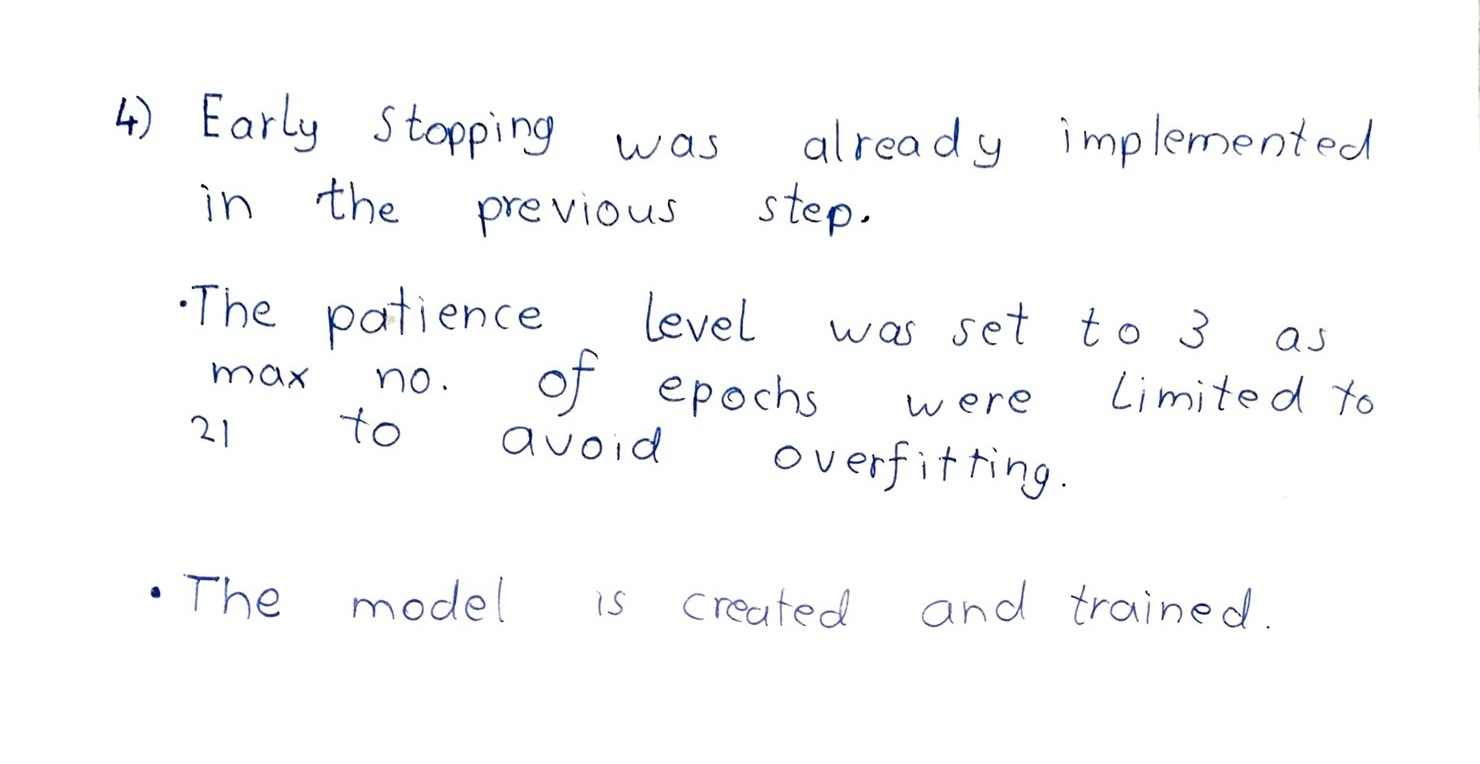

---

#### 5. Performance Evaluation

In [ ]:
# Printing Best Parameters
print("Best Parameters:", study.best_params)

Best Parameters: {'hidden_layers': 5, 'base_units': 118, 'unit_multiplier': 1.3053763942194998, 'min_units_for_dropout': 227, 'dropout': 0.16323123873946022, 'activation': 'sigmoid', 'optimizer': 'sgd', 'initial_learning_rate': 0.0017345507647002784, 'l2_reg': 0.00014000070052002097, 'batch_size': 67, 'epochs': 17}


In [ ]:
# Printing training and validation accuracy
print("Final training Accuracy:", history.history['accuracy'][-1])
print("Final validation Accuracy:", history.history['val_accuracy'][-1])
print()

Final training Accuracy: 0.8873765468597412
Final validation Accuracy: 0.8856944441795349



In [ ]:
# Training and Validation Accuracy for each Epoch
import pandas as pd

df = pd.DataFrame({
    'Epoch': range(1, len(history.history['accuracy']) + 1),
    'Training Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy']
})
df

,Epoch,Training Accuracy,Validation Accuracy
0,1,0.786281,0.833056
1,2,0.829969,0.838194
2,3,0.843086,0.849861
3,4,0.850247,0.856528
4,5,0.856281,0.852500
5,6,0.860324,0.860139
6,7,0.863133,0.866806
7,8,0.867994,0.871111
8,9,0.871497,0.878889
9,10,0.872778,0.878611


In [ ]:
# Printing final test accuracy on the untouched test set.
test_loss, test_accuracy = model.evaluate(augmented_x_test, augmented_y_test, verbose=0)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

Test set accuracy: 87.48%


<br><br><br><br><br><br>

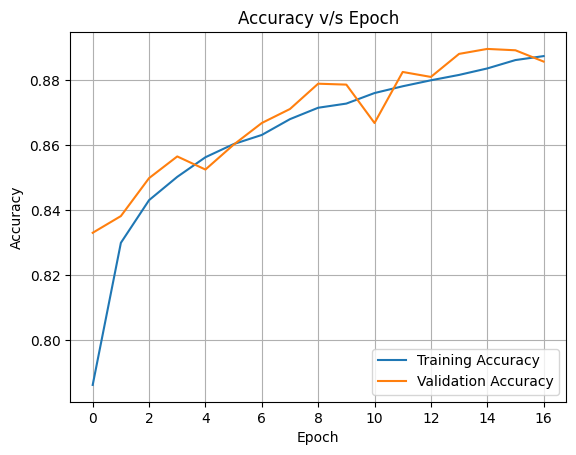

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy v/s Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

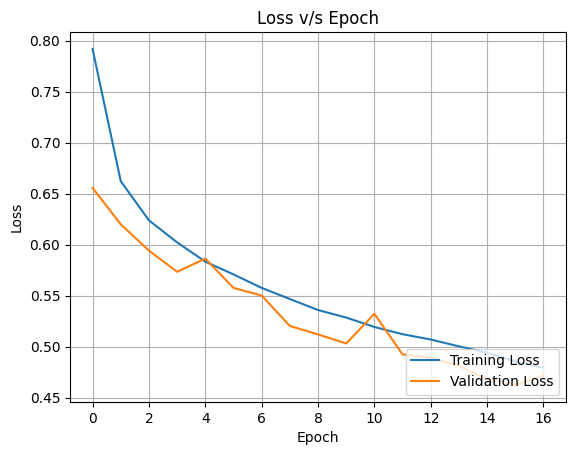

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss v/s Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

---
Explanation
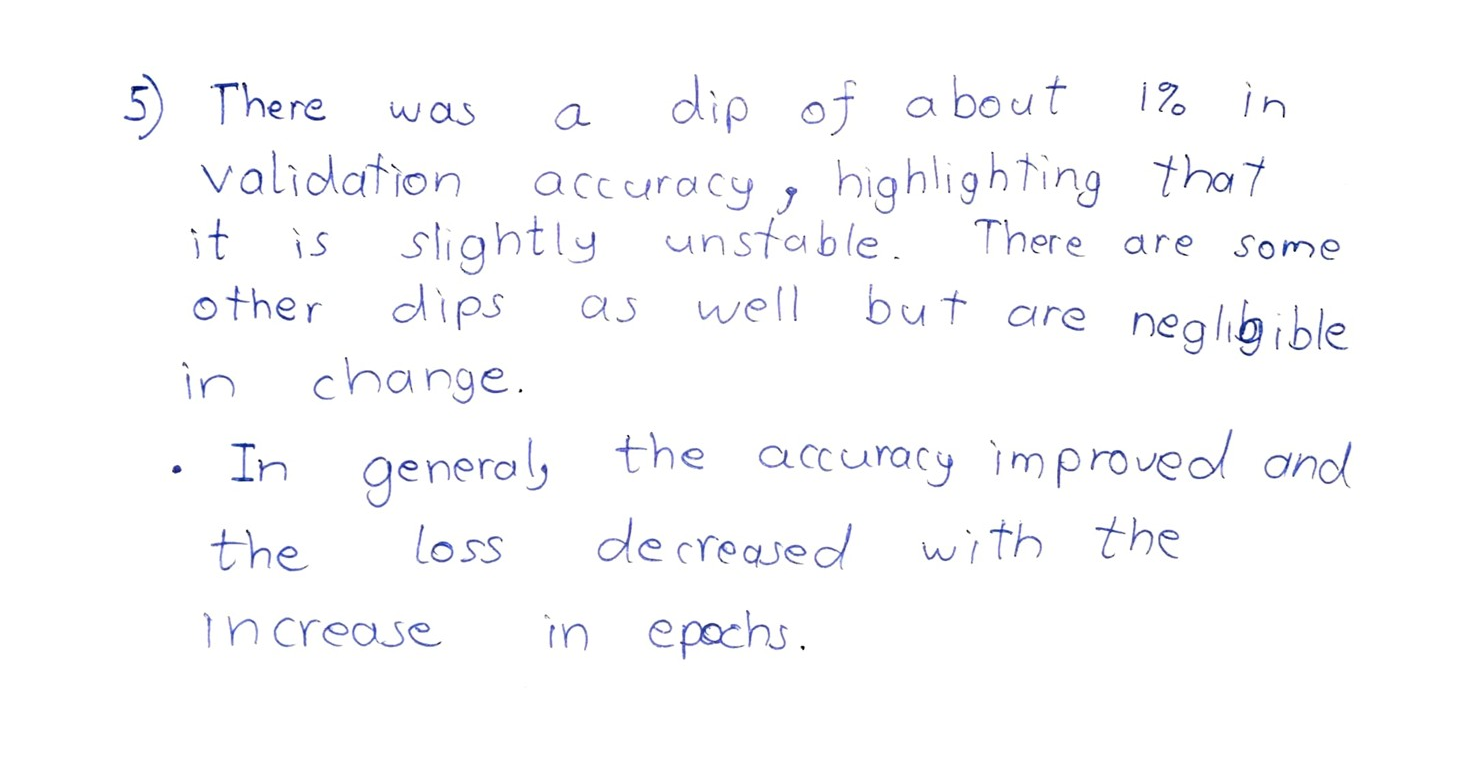

---

#### 6. Issue Identification and Analysis

---
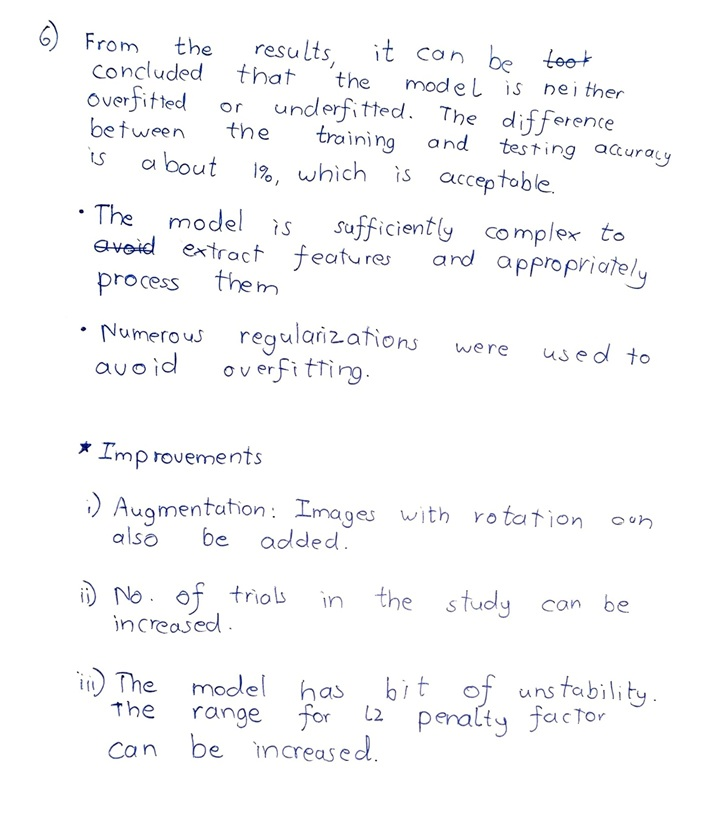

---

<br><br><br>